# Imports

In [86]:
# !pip install qiskit
# !pip install qiskit_aer
# !pip install qiskit_algorithms
# !pip install qiskit_ibm_runtime

In [87]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit (check versions)
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime

print(f"Qiskit version {qiskit.__version__}")
print(f"Qiskit Aer version {qiskit_aer.__version__}")
print(f"Qiskit algorithms version {qiskit_algorithms.__version__}")
print(f"Qiskit IBM runtime version {qiskit_ibm_runtime.__version__}")


# Quantum Circuits!
from qiskit import QuantumCircuit

# General Imports
from qiskit.synthesis import EvolutionSynthesis, SuzukiTrotter
from qiskit.circuit.library import UnitaryGate, PauliEvolutionGate
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, Pauli, DensityMatrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    thermal_relaxation_error,
    amplitude_damping_error
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

# Run time-evolution problems
from qiskit_algorithms.time_evolvers import TrotterQRTE, TimeEvolutionProblem

Qiskit version 2.2.3
Qiskit Aer version 0.17.2
Qiskit algorithms version 0.4.0
Qiskit IBM runtime version 0.43.1


# Auxiliary Functions

## Bloch Sphere

In [88]:
def bloch_from_state(state: list) -> list:
    """
        Get the Bloch vector from the coefficients of a given state.
    """

    # Get phases
    phi0 = np.angle(state[0])
    phi1 = np.angle(state[1])

    # Get angles
    theta = 2 * np.arccos(np.abs(state[0]))
    phi = phi1 - phi0

    return [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]

In [89]:
def plot_bloch(ss: list[Statevector], title: str, R: float = 0.99):
    """
        Plot the Bloch vectors of states in ss over time.
    """

    # Create a meshgrid with angular variables
    u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 30), np.linspace(0, np.pi, 20))

    # Convert spherical coordinates to Cartesian
    x = R * np.cos(u) * np.sin(v)
    y = R * np.sin(u) * np.sin(v)
    z = R * np.cos(v)

    # Create 3D figure
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot wireframe
    ax.plot_surface(x, y, z, color='b', alpha=0.05)
    ax.plot_wireframe(x, y, z, color='b', alpha=0.05)

    # Check we are dealing with single qubit states
    N = ss[0].num_qubits
    if N != 1:
        raise ValueError("Invalid state")
    
    # Build array of 3D Bloch vectors
    vx, vy, vz = [], [], []
    for state in ss:
        bx, by, bz = bloch_from_state([state[0], state[1]])
        vx += [bx]
        vy += [by]
        vz += [bz]

    # Now we can visualize the evolution of the magnetic polarization by plotting the polar and azimuthal angles over time
    # Initial is blue and final is red
    ax.plot(vx, vy, vz, color='g')
    ax.quiver(0, 0, 0, vx[0], vy[0], vz[0], color='b')
    ax.quiver(0, 0, 0, vx[-1], vy[-1], vz[-1], color='r')

    # Labeling
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.title(title)
    plt.show()

    return

## Running Simulations

In [90]:
def aersim(qc: QuantumCircuit, shots: int = 1024, noise: None | NoiseModel = None) -> dict[str, int]:
    # Create noisy simulator backend
    if noise:
        sim = AerSimulator(noise_model=noise)
    else:
        sim = AerSimulator()
    
    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(
        optimization_level=3, backend=sim
    )
    qc = passmanager.run(qc)

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts

## Hamiltonian Simulation

We want to simulate the following Hamiltonian:
\begin{align*}
    H = \sum_{j=0}^{n-1} 
    \underbrace{\left( 
    J_xX_j X_{j+1} + J_yY_j Y_{j+1} + J_zZ_j Z_{j+1} + z_j Z_j
    \right)}_{h_j},
\end{align*}

In [91]:
def hamiltonian(N: int, zz: np.ndarray, jj: list[float]) -> SparsePauliOp:
    """
        Build the Hamiltonian for our system with the specified parameters.
    """

    # Pauli Matrices
    X = SparsePauliOp("X")
    Y = SparsePauliOp("Y")
    Z = SparsePauliOp("Z")
    I = SparsePauliOp("I")

    # Coupled directions
    coupled = []
    if jj[0] != 0:
        coupled += [X]
    if jj[1] != 0:
        coupled += [Y]
    if jj[2] != 0:
        coupled += [Z]
    
    # Build Hamiltonian Term-by-Term
    tt = []

    # Apply XX, YY, and ZZ gates on index and index+1
    for index in range(N-1):
        for J, gate in zip(jj, coupled):
            term = gate ^ gate

            for _ in range(index):
                term = I ^ term
            
            for _ in range(index+2, N):
                term = term ^ I
            
            tt += [J * term]
    
    # Periodic Boundary Conditions
    for J, gate in zip(jj, coupled):
        term = gate.copy()
        for _ in range(N-2):
            term = term ^ gate
        term = term ^ gate

        tt += [J * term]

    # Apply field
    for index in range(N):
        term = Z.copy()

        for _ in range(index):
            term = I ^ term
        
        for _ in range(index+1, N):
            term = term ^ I
            
        tt += [zz[index] * term]
    
    # Build Hamiltonian
    ham = tt[0]
    for item in tt[1:]:
        ham += item

    return ham

In [92]:
def evolution(N: int, zz: np.ndarray, couple: list[float], order: int = 2, reps: int = 1, t: float = 0.1) -> PauliEvolutionGate:
    """
        Return the evolution operator for our Hamiltonian.
    """

    # Build the operator
    op = hamiltonian(N, zz, couple)

    # Get the evolution opeartor
    evo = PauliEvolutionGate(op, time=t, label="U", synthesis=SuzukiTrotter(order, reps))

    return evo

In [93]:
def direct_sim(state: Statevector, N: int, zz: np.ndarray, couple: list[float], order: int = 2, reps: int = 1, dt: float = 0.1, t: float = 2) -> tuple[list[int], list[Statevector]]:
    """
        Directly simulates the time-evolution using a single evolution operator.
    """

    # Get the evolution operator
    evo = evolution(N, zz, couple, order, reps, dt)

    # Number of steps
    steps = int(t/dt) + 1

    tt = [0]
    ss = [state]
    for index in range(steps):
        # Build the quantum circuit
        qc = QuantumCircuit(N)
        qc.initialize(state)
        qc.append(evo, range(N))

        # Get the final state
        state = Statevector(qc)

        # Save values
        tt += [dt * (index + 1)]
        ss += [state]
    
    return tt, ss

# Simulations

## One Qubit

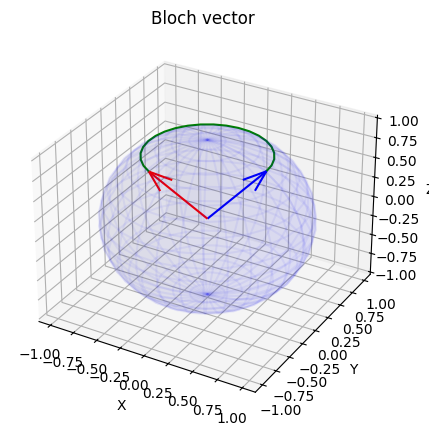

Initial state is blue and final is red.


In [94]:
# Simulation with one-qubit align to the field

# Parameters
state = Statevector([np.sqrt(0.90), np.sqrt(0.10)])
N = 1
zz = np.array([1])

# Run the simulation
tt, ss = direct_sim(state, N, zz, couple=[0, 0, 0])

# View the results
plot_bloch(ss, "Bloch vector")
print("Initial state is blue and final is red.")